# Technical notebook - data modelling

In [1]:
# Import python modules
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

## Data preparation

In [2]:
# Load data
student_df = pd.read_csv('data/studentInfo.csv')

We have analyzed the new data and seen that all the missing values in the student_info table from Scottish students are now present.<br/>
The only missing values are now in the imd_band column. There are not many of them, so we can just drop them.

In [3]:
student_df.dropna(subset=['imd_band'], inplace=True)
student_df.reset_index(drop=True, inplace=True)

The target variable is the final result.

The "Pass" and "Distinction" values can be grouped together as "Pass".
The "Withdrawn" values do not provide any information, so we can drop them.

In [4]:
# drop Widthdrawn
student_df = student_df[student_df['final_result'] != 'Withdrawn']

In [5]:
# Target variable: final_result
y = student_df[['final_result']]

# convert Pass and Distinction to 1 and Fail to 0
y = y.replace(['Pass', 'Distinction', 'Fail'], [0, 0, 1])

# Features: gender, region, highest education, IMD score, age, number of previous attempts, studied credits and disability
x = student_df[['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'studied_credits', 'num_of_prev_attempts', 'disability']]

In [6]:
# Verify there are no missing values
print(x.isnull().sum())
print(y.isnull().sum())

gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
studied_credits         0
num_of_prev_attempts    0
disability              0
dtype: int64
final_result    0
dtype: int64


Next We need to convert the categorical data into numerical data, so we can use it in the models.

In [7]:
le = LabelEncoder()
x['gender'] = le.fit_transform(x['gender'])
x['disability'] = le.fit_transform(x['disability'])
x['imd_band'] = le.fit_transform(x['imd_band'])
x['age_band'] = le.fit_transform(x['age_band'])
x['region'] = le.fit_transform(x['region'])
x['highest_education'] = le.fit_transform(x['highest_education'])

x.head()

,gender,region,highest_education,imd_band,age_band,studied_credits,num_of_prev_attempts,disability
0,1,0,1,9,2,240,0,0
1,0,6,1,2,1,60,0,0
3,0,7,0,5,1,60,0,0
4,0,11,2,5,0,60,0,0
5,1,10,0,8,1,60,0,0


Split the data into train and test sets.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

# Turn y_train and y_test into 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

## 🖼️ Model template

In [9]:
class Model:
    def __init__(self, model, name, x_train, y_train, x_test, y_test):
        self.model = model
        self.name = name

        self.x_train = x_train
        self.y_train = y_train
        self.fit(x_train, y_train)

        self.cross_val_score = self.get_cross_val_score(x_train, y_train)

        self.x_test = x_test
        self.y_test = y_test
        y_pred = self.predict(x_test)

        self.accuracy = self.get_accuracy(y_test, y_pred)
        self.precision = self.get_precision(y_test, y_pred)
        self.recall = self.get_recall(y_test, y_pred)
        self.f1 = self.get_f1(y_test, y_pred)
        self.confusion_matrix = self.get_confusion_matrix(y_test, y_pred)
        self.learning_curve = self.get_learning_curve(x_train, y_train)

    def fit(self, x, y):
        self.model.fit(x, y)

    def predict(self, x):
        return self.model.predict(x)

    def get_model(self):
        return self.model

    def get_accuracy(self, y_true, y_pred):
        self.accuracy = metrics.accuracy_score(y_true, y_pred)
        return self.accuracy

    def get_precision(self,  y_true, y_pred):
        self.precision = metrics.precision_score(y_true, y_pred)
        return self.precision

    def get_recall(self, y_true, y_pred):
        self.recall = metrics.recall_score(y_true, y_pred)
        return self.recall

    def get_f1(self, y_true, y_pred):
        self.f1 = metrics.f1_score(y_true, y_pred)
        return self.f1

    def get_cross_val_score(self, x, y):
        self.cross_val_score = cross_val_score(self.model, x, y, cv=5)
        return self.cross_val_score

    def get_confusion_matrix(self, y_true, y_pred):
        self.confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
        return self.confusion_matrix

    def get_learning_curve(self, x, y):
        self.learning_curve = learning_curve(self.model, x, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.01, 1.0, 25))
        return self.learning_curve

    def print_cross_val_score(self):
        print('Cross Validation Score: ')
        for i in range(len(self.cross_val_score)):
            print('Fold ', i+1, ': ', round(self.cross_val_score[i], 4))

    def print_metrics(self):
        print('Metrics for', self.name)
        print('Accuracy:\t', round(self.accuracy, 4))
        print('Precision:\t', round(self.precision, 4))
        print('Recall:\t\t', round(self.recall, 4))
        print('F1:\t\t', round(self.f1, 4))

    def plot_confusion_matrix(self):
        cm = self.confusion_matrix
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pass', 'Fail'])
        disp.plot()
        plt.title(self.name + " Confusion Matrix")
        plt.show()

    def plot_learning_curve(self):
        train_sizes, train_scores, test_scores = self.learning_curve
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        plt.title(self.name + " Learning Curve")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.grid()
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.show()

## 📊 Models

### Decision Tree

In [10]:
decision_tree = Model(tree.DecisionTreeClassifier(max_depth=5), 'Decision Tree Classifier', x_train, y_train, x_test, y_test);

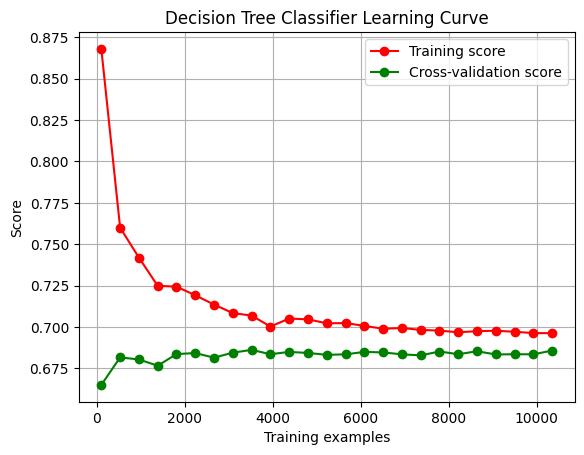

In [11]:
decision_tree.plot_learning_curve()

In [12]:
decision_tree.print_metrics()

Metrics for Decision Tree Classifier
Accuracy:	 0.6813
Precision:	 0.5036
Recall:		 0.2028
F1:		 0.2891


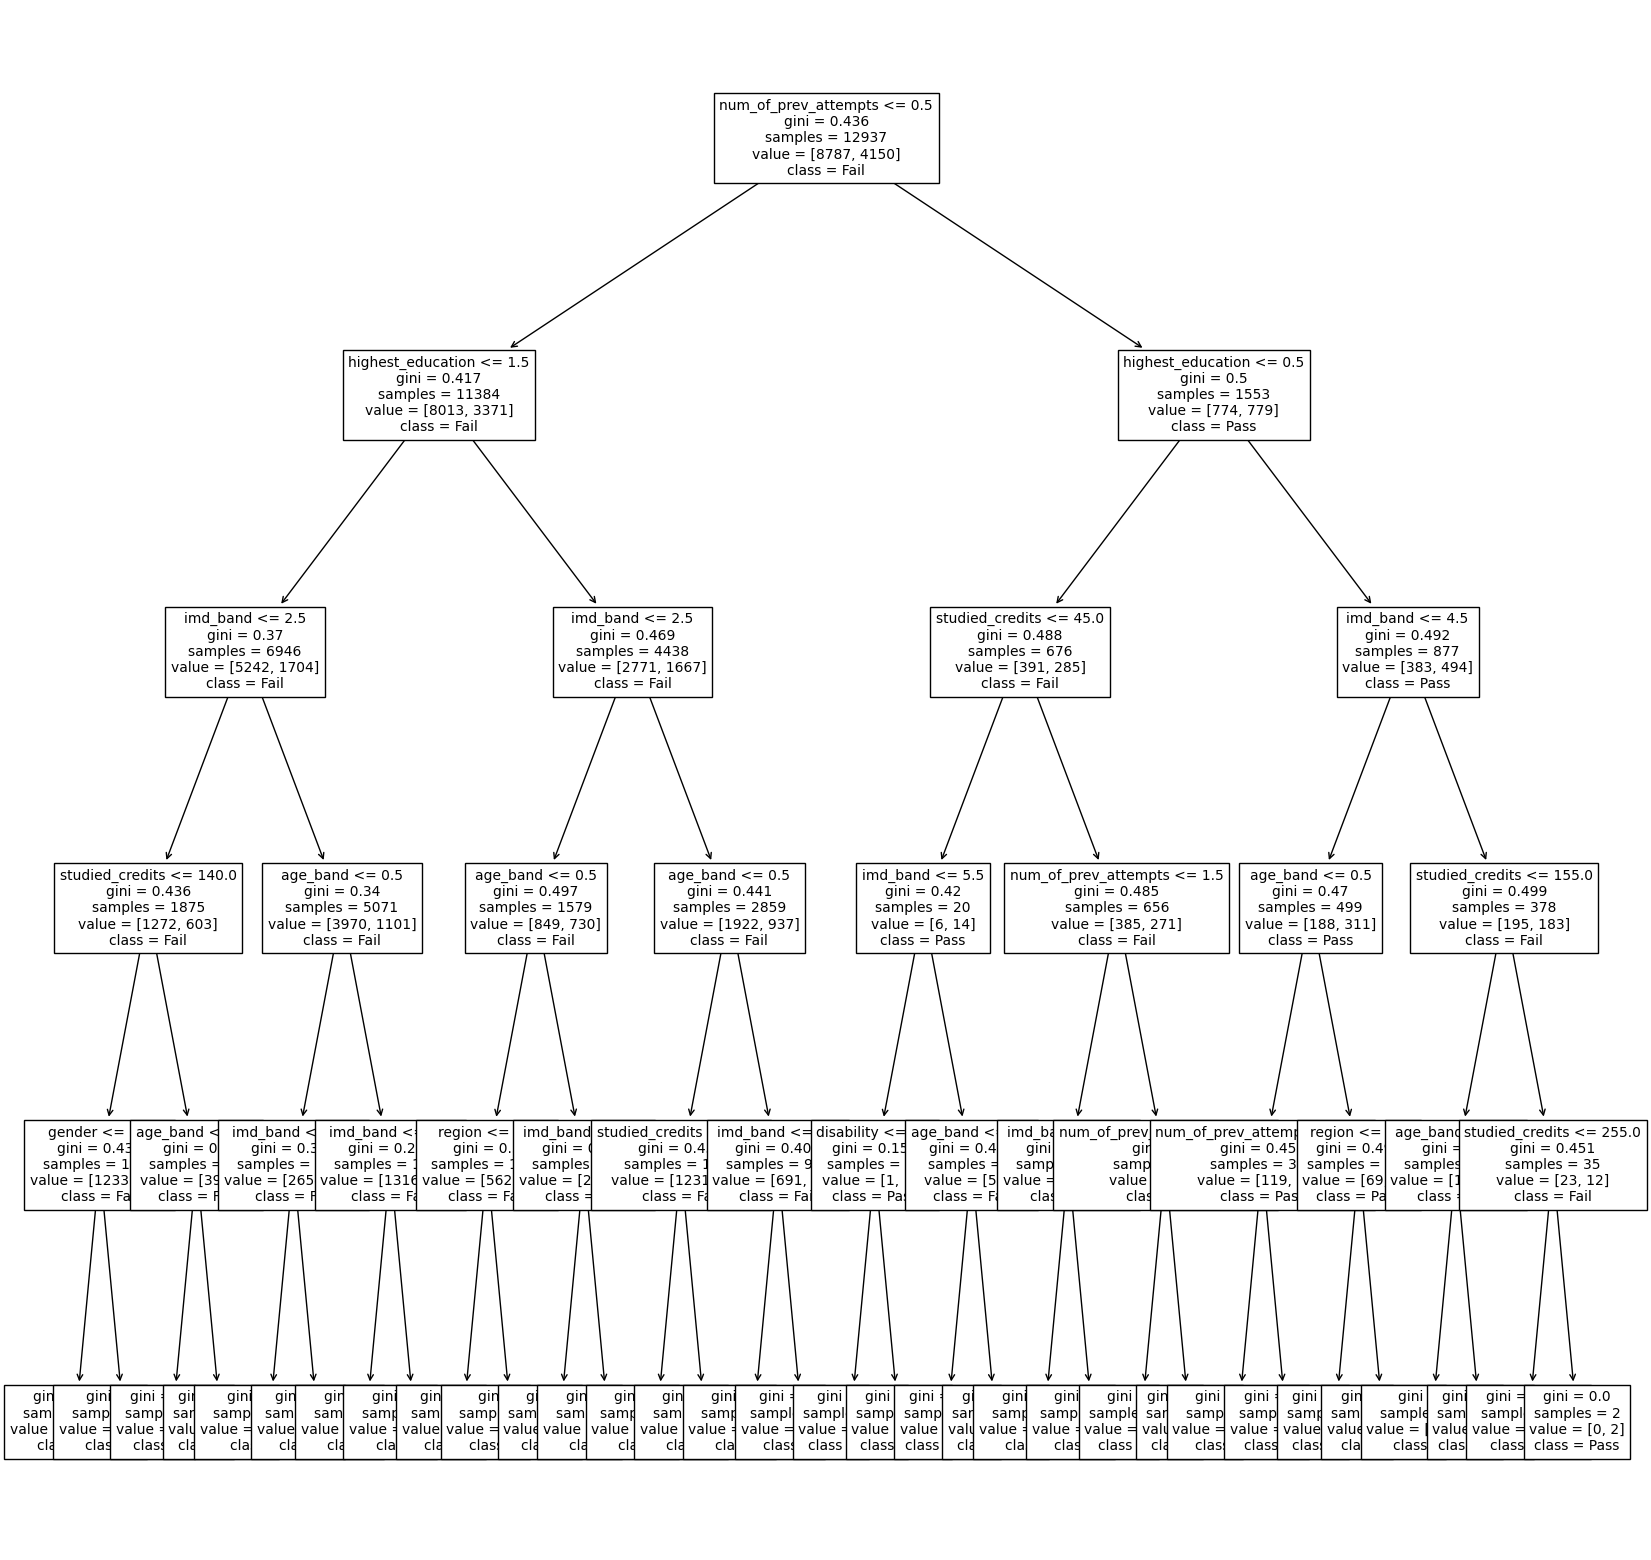

In [13]:
# plot decision tree
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(decision_tree.get_model(), ax=ax, fontsize=10, feature_names=x.columns, class_names=['Fail', 'Pass'])
plt.show()

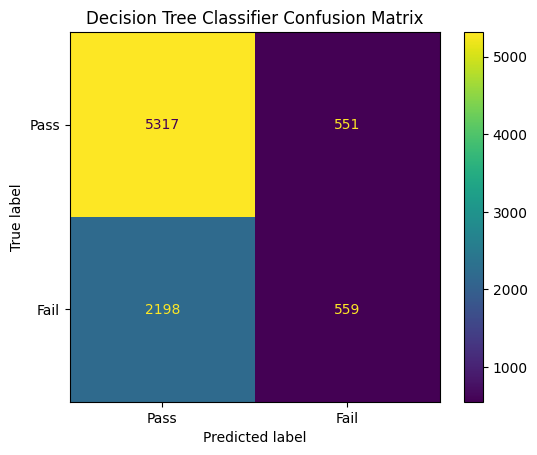

In [14]:
decision_tree.plot_confusion_matrix()

### Random Forest

In [15]:
random_forest = Model(RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0), 'Random Forest Classifier', x_train, y_train, x_test, y_test)

In [16]:
random_forest.print_metrics()

Metrics for Random Forest Classifier
Accuracy:	 0.6865
Precision:	 0.6
Recall:		 0.0577
F1:		 0.1052


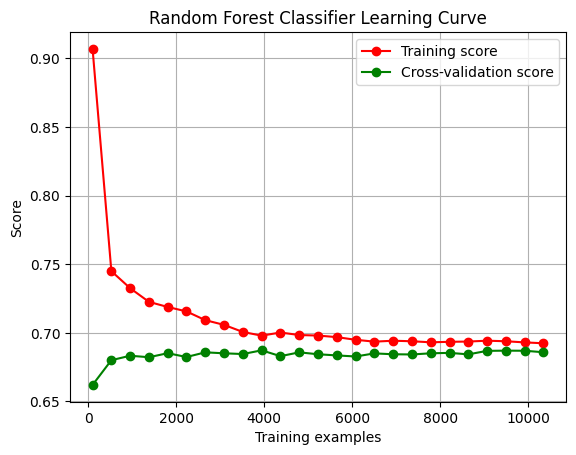

In [17]:
random_forest.plot_learning_curve()

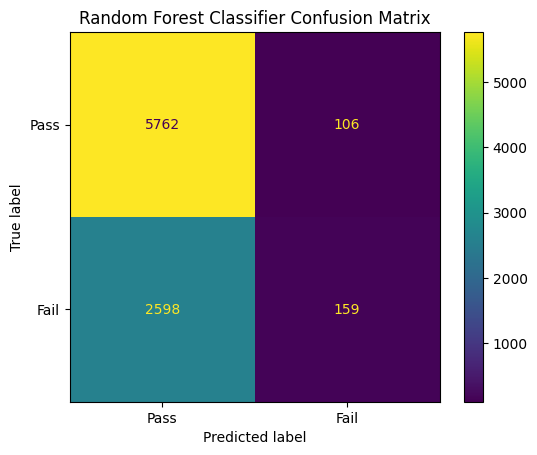

In [18]:
random_forest.plot_confusion_matrix()

### Logistic Regression

In [19]:
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=500)
logistic_regression = Model(lr, 'Logistic Regression', x_train, y_train, x_test, y_test)

In [20]:
logistic_regression.print_metrics()

Metrics for Logistic Regression
Accuracy:	 0.6866
Precision:	 0.5525
Recall:		 0.103
F1:		 0.1736


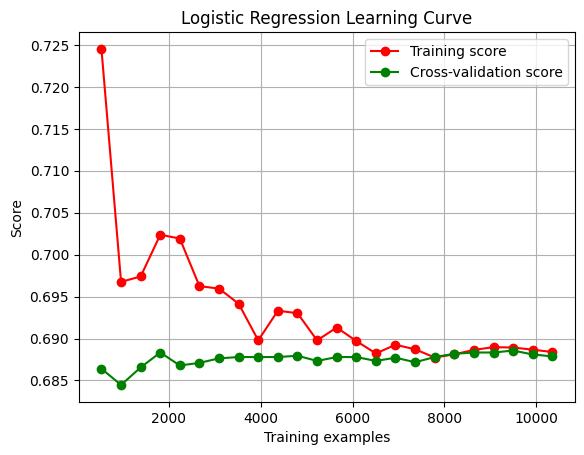

In [21]:
logistic_regression.plot_learning_curve()

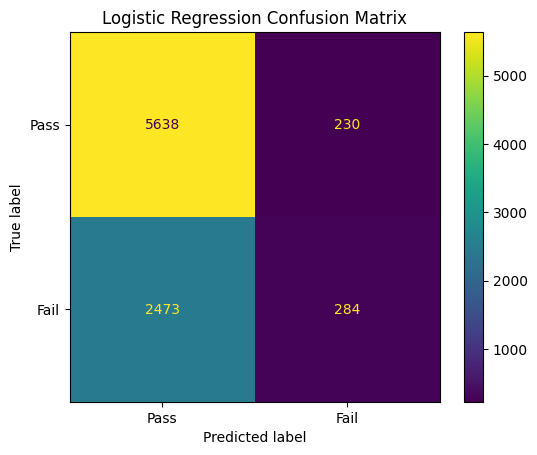

In [57]:
logistic_regression.plot_confusion_matrix()

### K-Nearest Neighbors

In [22]:
knn = Model(KNeighborsClassifier(n_neighbors=5), 'K Nearest Neighbors', x_train, y_train, x_test, y_test)

In [23]:
knn.print_metrics()

Metrics for K Nearest Neighbors
Accuracy:	 0.6373
Precision:	 0.3999
Recall:		 0.2688
F1:		 0.3215


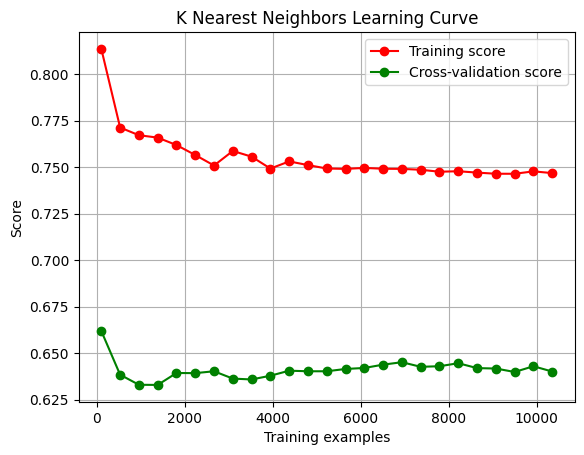

In [24]:
knn.plot_learning_curve()

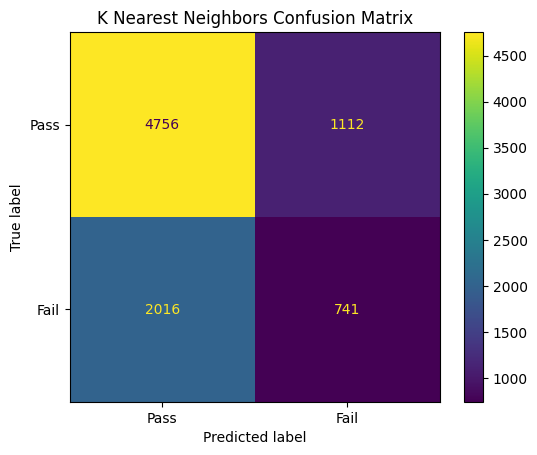

In [25]:
knn.plot_confusion_matrix()

### Gaussian Naive Bayes

In [26]:
gaussian_nb = Model(GaussianNB(), 'Gaussian Naive Bayes', x_train, y_train, x_test, y_test)

In [27]:
gaussian_nb.print_metrics()

Metrics for Gaussian Naive Bayes
Accuracy:	 0.667
Precision:	 0.4557
Recall:		 0.2147
F1:		 0.2919


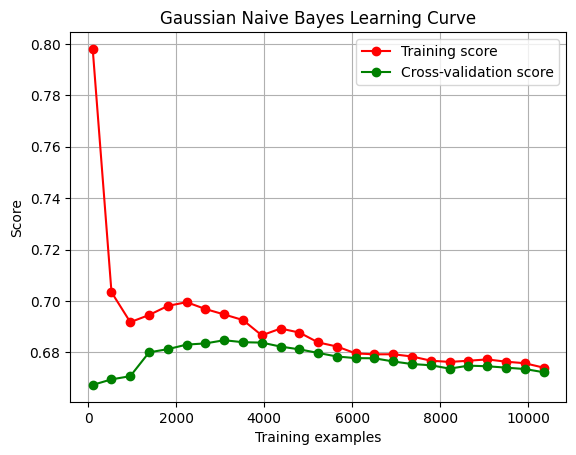

In [28]:
gaussian_nb.plot_learning_curve()

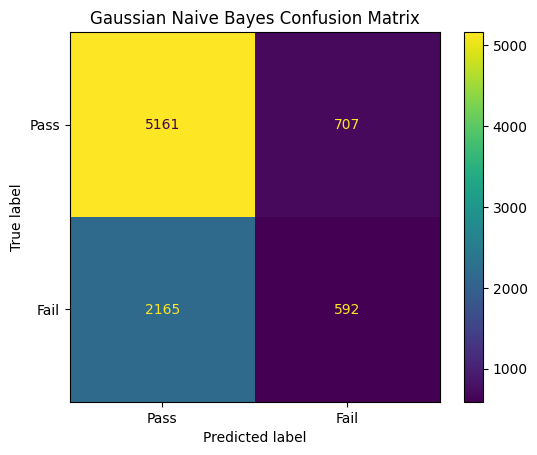

In [29]:
gaussian_nb.plot_confusion_matrix()

### Bernoulli Naive Bayes

In [30]:
bernoulli_nb = Model(BernoulliNB(), 'Bernoulli Naive Bayes', x_train, y_train, x_test, y_test)

In [31]:
bernoulli_nb.print_metrics()

Metrics for Bernoulli Naive Bayes
Accuracy:	 0.6839
Precision:	 0.5269
Recall:		 0.1103
F1:		 0.1824


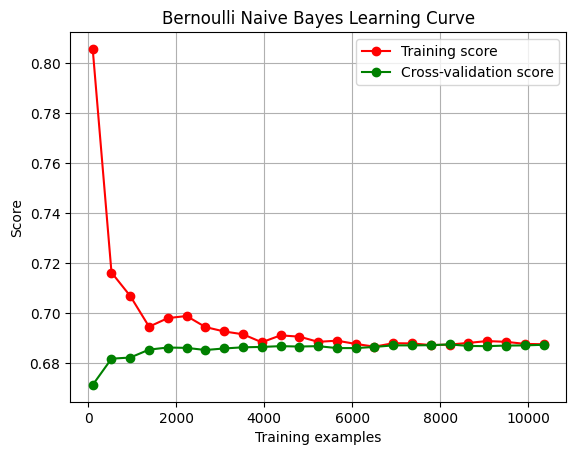

In [32]:
bernoulli_nb.plot_learning_curve()

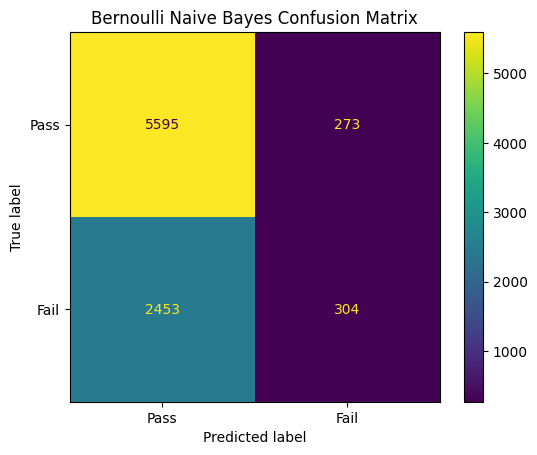

In [33]:
bernoulli_nb.plot_confusion_matrix()

### Support Vector Machine

#### Linear

In [34]:
svc_linear = Model(SVC(kernel='linear'), 'Support Vector Machine', x_train, y_train, x_test, y_test)

In [35]:
svc_linear.print_metrics()

Metrics for Support Vector Machine
Accuracy:	 0.6844
Precision:	 0.5814
Recall:		 0.0453
F1:		 0.0841


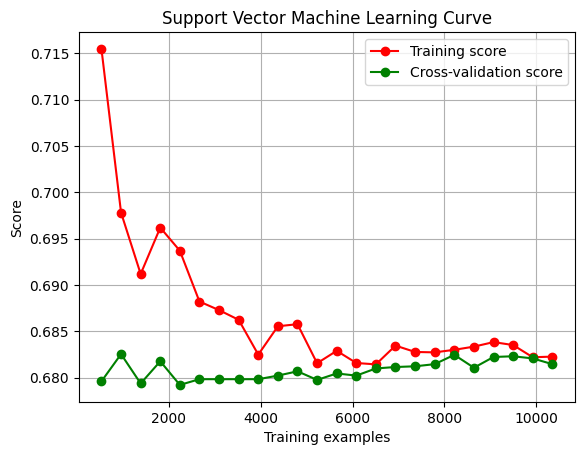

In [36]:
svc_linear.plot_learning_curve()

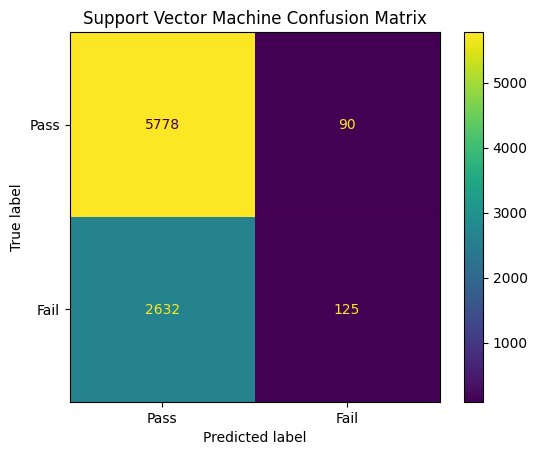

In [37]:
svc_linear.plot_confusion_matrix()

#### RBF

In [38]:
svc_rbf = Model(SVC(kernel='rbf'), 'Support Vector Machine RBF', x_train, y_train, x_test, y_test)

In [39]:
svc_rbf.print_metrics()

Metrics for Support Vector Machine RBF
Accuracy:	 0.6799
Precision:	 0.1667
Recall:		 0.0004
F1:		 0.0007


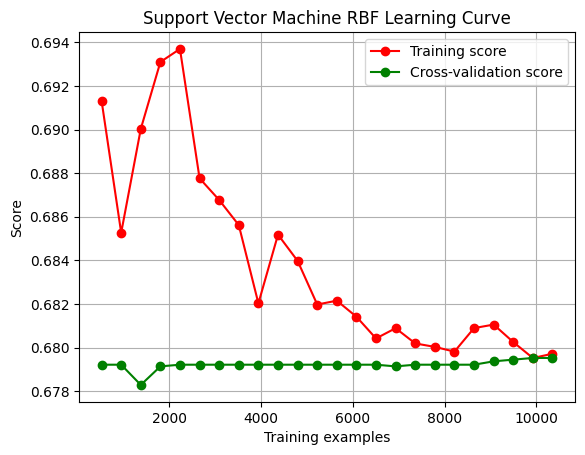

In [40]:
svc_rbf.plot_learning_curve()

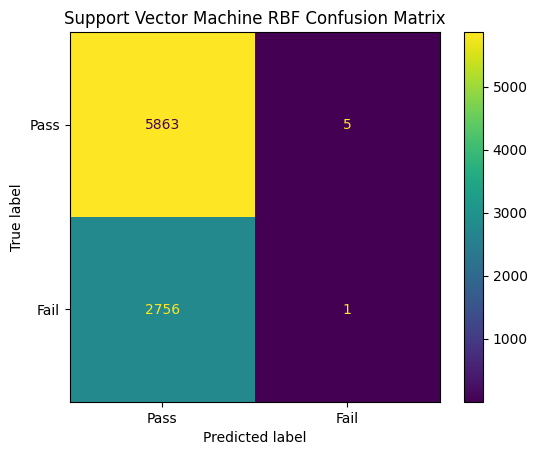

In [41]:
svc_rbf.plot_confusion_matrix()

#### Polynomial

In [42]:
svc_poly = Model(SVC(kernel='poly'), 'Support Vector Machine Poly', x_train, y_train, x_test, y_test)

In [43]:
svc_poly.print_metrics()

Metrics for Support Vector Machine Poly
Accuracy:	 0.681
Precision:	 0.875
Recall:		 0.0025
F1:		 0.0051


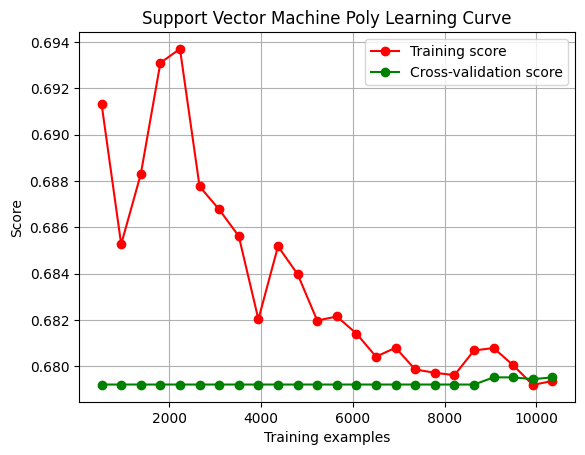

In [44]:
svc_poly.plot_learning_curve()

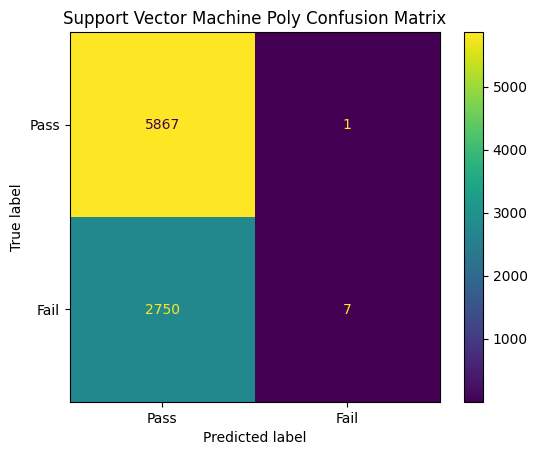

In [45]:
svc_poly.plot_confusion_matrix()

#### Sigmoid

In [46]:
svc_sigmoid = Model(SVC(kernel='sigmoid'), 'Support Vector Machine Sigmoid', x_train, y_train, x_test, y_test)

In [47]:
svc_sigmoid.print_metrics()

Metrics for Support Vector Machine Sigmoid
Accuracy:	 0.5761
Precision:	 0.3342
Recall:		 0.3286
F1:		 0.3314


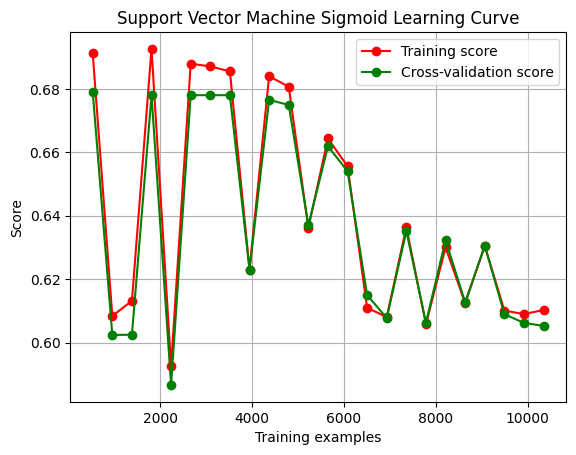

In [48]:
svc_sigmoid.plot_learning_curve()

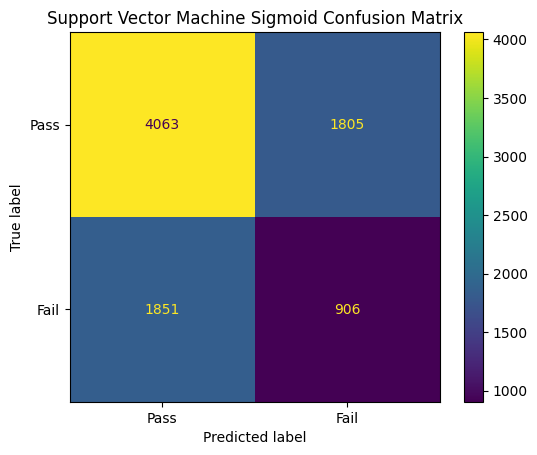

In [49]:
svc_sigmoid.plot_confusion_matrix()

### Neural Network

In [228]:
neural_network = Sequential()

neural_network.add(Dense(16, input_dim=x_train.shape[1], activation='relu'))

neural_network.add(Dense(128, activation='relu'))
neural_network.add(Dense(64, activation='relu'))
neural_network.add(Dense(32, activation='relu'))

neural_network.add(Dense(1, activation='sigmoid'))

neural_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [229]:
# Split training data into training and validation data
x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [230]:
# Train neural network
history = neural_network.fit(x_train2, y_train2, epochs=10, batch_size=10, validation_data=(x_val, y_val))

Epoch 1/10
1035/1035 [==============================] - 2s 2ms/step - loss: 0.6502 - accuracy: 0.6606 - val_loss: 0.6181 - val_accuracy: 0.6731
Epoch 2/10
1035/1035 [==============================] - 2s 2ms/step - loss: 0.6207 - accuracy: 0.6780 - val_loss: 0.6045 - val_accuracy: 0.6928
Epoch 3/10
1035/1035 [==============================] - 2s 2ms/step - loss: 0.6196 - accuracy: 0.6763 - val_loss: 0.6116 - val_accuracy: 0.6951
Epoch 4/10
1035/1035 [==============================] - 2s 2ms/step - loss: 0.6121 - accuracy: 0.6823 - val_loss: 0.6055 - val_accuracy: 0.6812
Epoch 5/10
1035/1035 [==============================] - 2s 2ms/step - loss: 0.6076 - accuracy: 0.6854 - val_loss: 0.6128 - val_accuracy: 0.6808
Epoch 6/10
1035/1035 [==============================] - 2s 2ms/step - loss: 0.6085 - accuracy: 0.6844 - val_loss: 0.6066 - val_accuracy: 0.6855
Epoch 7/10
1035/1035 [==============================] - 2s 2ms/step - loss: 0.6072 - accuracy: 0.6835 - val_loss: 0.6012 - val_accuracy:

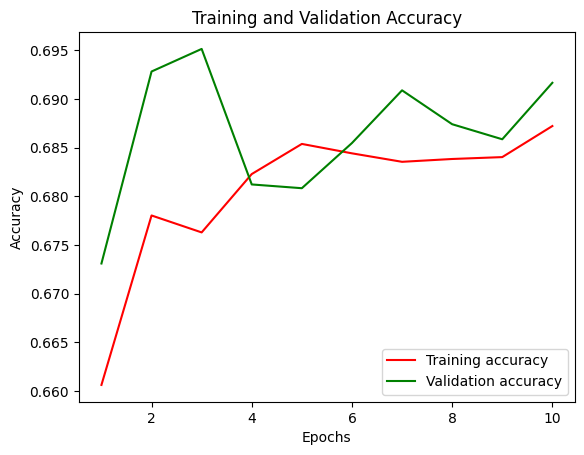

In [231]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy
plt.plot(range(1, len(train_acc) + 1), train_acc, 'r', label='Training accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [232]:
y_pred = neural_network.predict(x_test)
y_pred = (y_pred > 0.5)

270/270 [==============================] - 0s 914us/step


In [233]:
print("Accuracy:\t", round(metrics.accuracy_score(y_test, y_pred), 4))
print("Precision:\t", round(metrics.precision_score(y_test, y_pred), 4))
print("Recall:\t\t", round(metrics.recall_score(y_test, y_pred), 4))
print("F1:\t\t", round(metrics.f1_score(y_test, y_pred), 4))

Accuracy:	 0.6857
Precision:	 0.5337
Recall:		 0.132
F1:		 0.2117


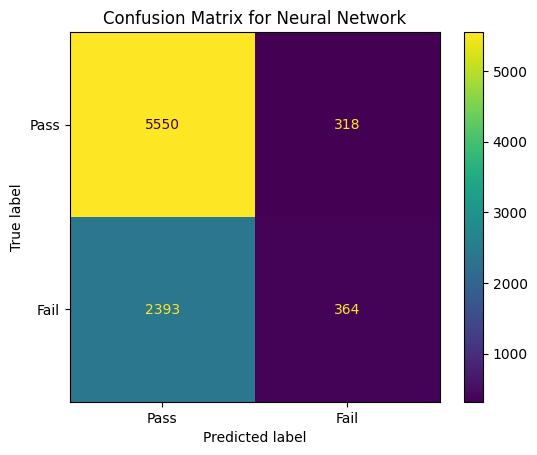

In [234]:
# Confusion matrix for neural network
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pass', 'Fail'])
disp.plot()
plt.title('Confusion Matrix for Neural Network')
plt.show()

## 📝 TODO: Model Selection